In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as graph

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


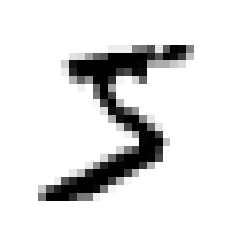

In [13]:
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

graph.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
graph.axis("off")
graph.show()

In [17]:
y = y.astype(int)

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=60000)

# Train a Binary classifier

In [35]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Trying a Stochastic Gradient Descent (SGD)

In [38]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

Evaluating a classifier is often trickier than a regressor

## Measuring accuracy cross-validation

### Implementing cross validation

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds, y_train_folds = x_train[train_index], y_train_5[train_index]
    x_test_fold, y_test_fold = x_train[test_index], y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.96185
0.96445
0.92405


In [42]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.96185, 0.96445, 0.92405])

In [44]:
from sklearn.base import BaseEstimator

class Never5classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

In [45]:
never_5_clf = Never5classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=5, scoring='accuracy')

array([0.91058333, 0.90791667, 0.91066667, 0.90883333, 0.9105    ])

### Confusion matrix
This is a better way of looking at the accuracy of classifiers <br>
Again, we do not touch the test set before the very last part of our projecy

In [46]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [47]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52546,  2036],
       [  957,  4461]])

Each row is the actual class and the columns is the predicted class <br>
First row is the negative class, and first column is the negative class. So first 'cell' are the true negatives

In [50]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54582,     0],
       [    0,  5418]])

## Precision and Recall

Precision is specificity. So true positives / predicted positives<br>
$$Precision = \frac{True Positive}{True Positive + False Positive}$$

Recall is sensitivity. So true positives / actual positives<br>
$$Precision = \frac{True Positive}{True Positive + False Negative}$$

In [56]:
from sklearn.metrics import precision_score, recall_score

prec_score = precision_score(y_train_5, y_train_pred)
rec_score = recall_score(y_train_5, y_train_pred)

print(f'Precision is = {prec_score} and means only correct {(prec_score * 100).round(1)} % of times')
print(f'Recall is = {rec_score} and detect only {(rec_score * 100).round(1)} %')

Precision is = 0.6866245959673696 and means only correct 68.7 % of times
Recall is = 0.8233665559246954 and detect only 82.3 %


In [57]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7488040285354596

# Precision/Recall Tradeoff

In [58]:
# get decision scores of functions

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[369.32158384]
[ True]


In [59]:
threshold = 8000

y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


Increasing threshold decreases recall but increases precision

In [60]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method = 'decision_function')

In [62]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [67]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold):
    graph.plot(thresholds, precisions[:-1], "b--", label='Precision')
    graph.plot(thresholds, recalls[:-1], 'g-', label='recall')
    graph.axvline(threshold, color='red', alpha=0.5)
    graph.legend()

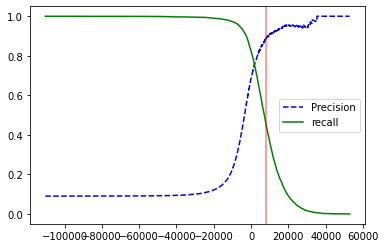

In [69]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold)
graph.show()

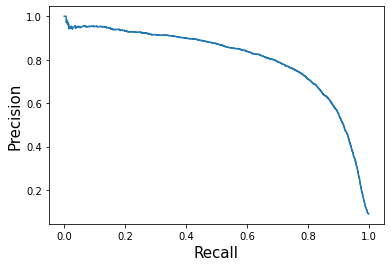

In [73]:
graph.plot(recalls[:-1], precisions[:-1])
graph.xlabel('Recall', fontsize=15)
graph.ylabel('Precision', fontsize=15)
graph.show()

In [74]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [76]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9
0.39867109634551495


# ROC CURVE

Plots recall (true positive rate) against false positive rate <br>
Plots sensitivity vs 1 - specificity

In [78]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [93]:
def plot_roc_curve(fpr, tpr, label=None):
    fontsize=15
    graph.plot(fpr, tpr, linewidth=2, label=label)
    graph.plot([0,1], [0,1], 'k--')
    graph.ylabel("sensitivity / Recall (True Positive)", fontsize=fontsize)
    graph.xlabel("1 - specificity (False positive)", fontsize=fontsize)

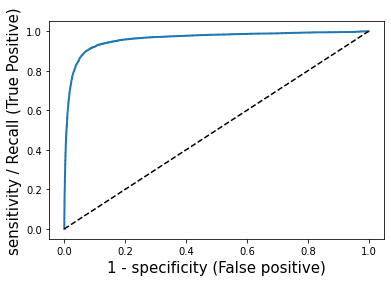

In [94]:
plot_roc_curve(fpr,tpr)
graph.show()

In [95]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9614902684206134

Use PR curve when positive class is rare or care more about false positives, and ROC curve otherwise

In [97]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

In [98]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

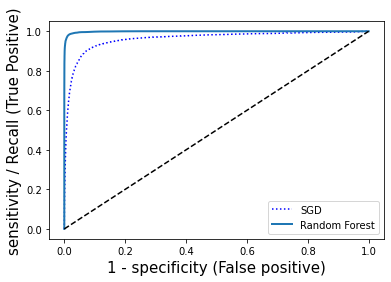

In [99]:
graph.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
graph.legend()
graph.show()

In [100]:
roc_auc_score(y_train_5, y_scores_forest)

0.9986335341183349

# Multiclass Classification

- Can handle multiclass: naive Bayes Classifier and Random Forest
- binaries, but can train one for each class, aggregate and get output from classifier with highest score (one-vs-all strategy)
- binaries one versus one (ex: 1 vs 2, 3 vs 4...)

In [101]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([5])

Trained 10 binary classifier here and got their scores

In [103]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(sgd_clf.classes_)

[[-15286.0639206  -24856.65363653  -9070.96911965  -1202.09893251
  -17204.7342339    1655.59513371 -28588.98038626 -12386.33649658
  -12624.72432684 -10265.48087171]]
[0 1 2 3 4 5 6 7 8 9]


#### A one-vs-one classifier

In [104]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([5])

In [106]:
forest_clf.fit(x_train, y_train)
forest_clf.predict_proba([some_digit])

array([[0.  , 0.02, 0.02, 0.19, 0.02, 0.69, 0.  , 0.01, 0.04, 0.01]])

In [108]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.8927 , 0.88115, 0.8654 ])

In [109]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(float))

In [110]:
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


KeyboardInterrupt: 

# Error Analysis

In [112]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)

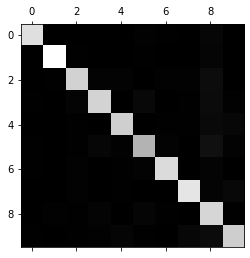

In [113]:
graph.matshow(conf_mx, cmap=graph.cm.gray)
graph.show()

Let's focus on the errors

In [114]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums_sums

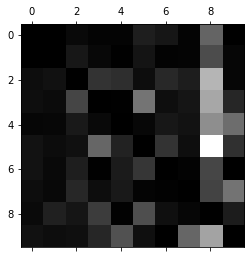

In [115]:
np.fill_diagonal(norm_conf_mx, 0)

graph.matshow(norm_conf_mx, cmap=graph.cm.gray)
graph.show()

Seems like there's more error for 8. Can improve by getting more data for 8, or engineer new features to help

# Multilabel classification

In [116]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [117]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [118]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [119]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

KeyboardInterrupt: 

Here it gave all labels equal importance. If we want to have more weight on some labels (ex, there are more of one label than others), can change " average = 'weighted' " above

# Multioutput Classification

In [120]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise

noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise

y_train_mod = x_train
y_test_mod = x_test

In [124]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[2]])

plot_digit(clean_digit)

NameError: name 'plot_digit' is not defined

# Exercises

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [ ]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params_grid = [{'n_neighbors': [4, 5, 6, 7], 'weights': ['uniform', 'distance']}]

knn_clf = KNeighborsClassifier()
grid_knn = GridSearchCV(knn_clf, params_grid, cv=5, verbose=3, n_jobs=-1)
grid_knn.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
print(grid_knn.best_params_)
print(grid_knn.best_score_)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion.

In [135]:
from scipy.ndimage.interpolation import shift

def image_shifter(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, shift=[dx, dy])
    return shifted_image.reshape([-1])

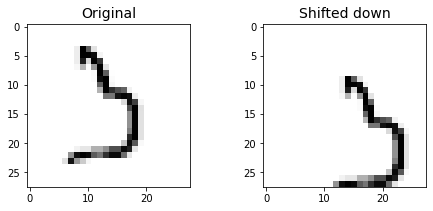

In [138]:
image = x_train[1000]
shifted_image = image_shifter(image, 5, 5)

graph.figure(figsize=(12,3))

graph.subplot(131)
graph.title("Original", fontsize=14)
graph.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")

graph.subplot(132)
graph.title("Shifted down", fontsize=14)
graph.imshow(shifted_image.reshape(28, 28), interpolation="nearest", cmap="Greys")

graph.show()

In [151]:
copy_x_train, copy_y_train = x_train.copy(), y_train.copy()

In [159]:
x_train = [image for image in copy_x_train]
y_train = [label for label in copy_y_train]

# for x, y in ((1, 0), (-1, 0), (0, 1), (0, -1)):
#     for image, label in zip(x_train, y_train):
#         image.append(image_shifter(image, [x, y]))
#         label.append(label)

In [161]:
x_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
x_train_augmented = [image for image in x_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(x_train, y_train):
        x_train_augmented.append(image_shifter(image, dx, dy))
        y_train_augmented.append(label)

x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

3. Tackle the Titanic dataset. A great place to start is on Kaggle.

4. Build a spam classifier (a more challenging exercise):
- Download examples of spam and ham from Apache SpamAssassin’s public
datasets.
- Unzip the datasets and familiarize yourself with the data format.
- Split the datasets into a training set and a test set.
- Write a data preparation pipeline to convert each email into a feature vector.
Your preparation pipeline should transform an email into a (sparse) vector
indicating the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.
- You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).
- Then try out several classifiers and see if you can build a great spam classifier,
with both high recall and high precision.